In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import kagglehub

In [ ]:

path = kagglehub.dataset_download("rgupta12/metro-interstate-traffic-volume")

print("Path to dataset files:", path)

100%|██████████| 1.12M/1.12M [00:00<00:00, 2.16MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rgupta12/metro-interstate-traffic-volume/versions/1


In [ ]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/rgupta12/metro-interstate-traffic-volume/versions/1/Metro_Interstate_Traffic_Volume.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


✅ MODEL EVALUATION
Training MSE      : 28406.65
Training R² Score : 0.9928
Testing MSE       : 202484.19
Testing R² Score  : 0.9488


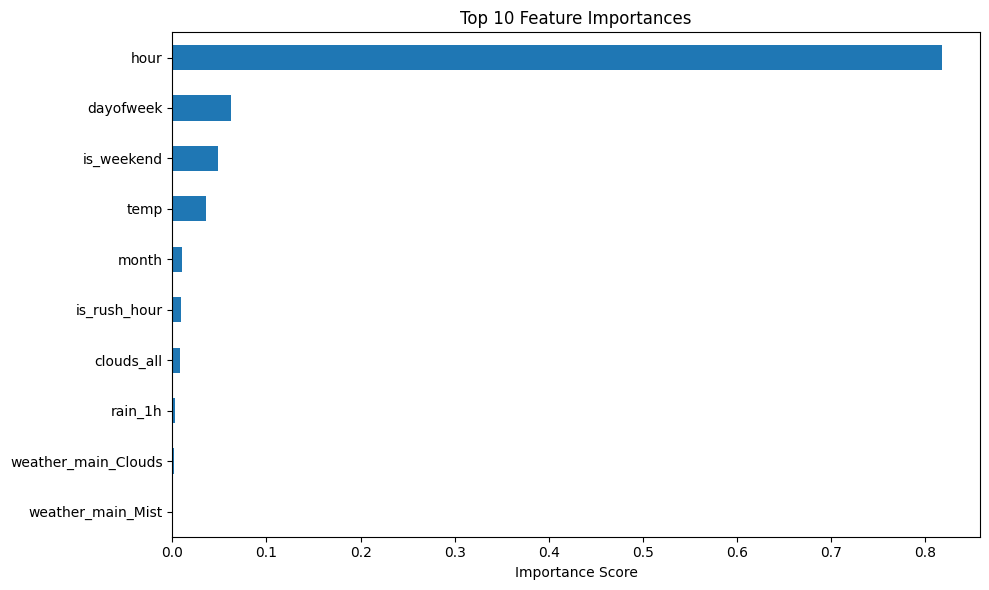

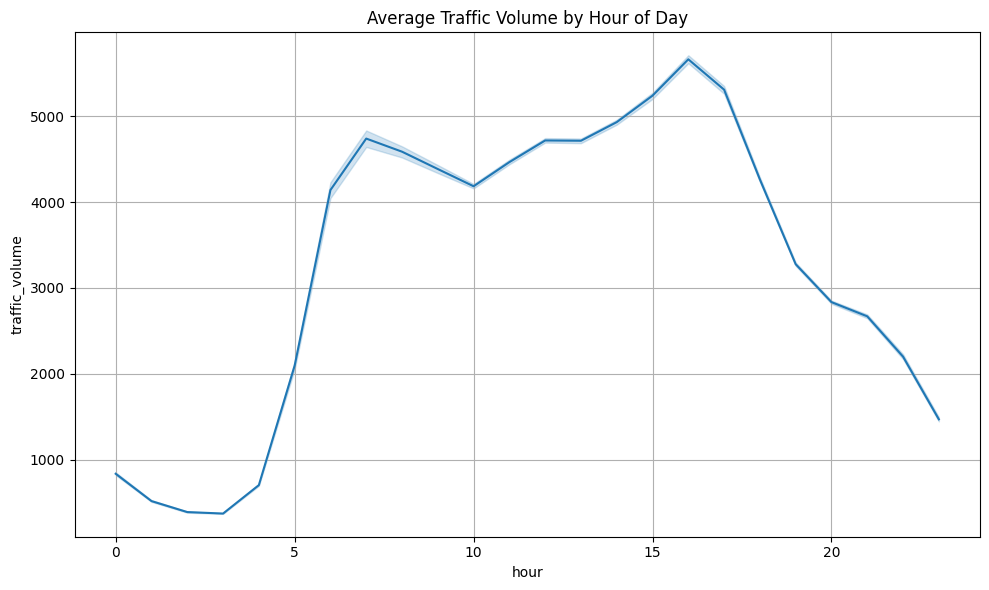

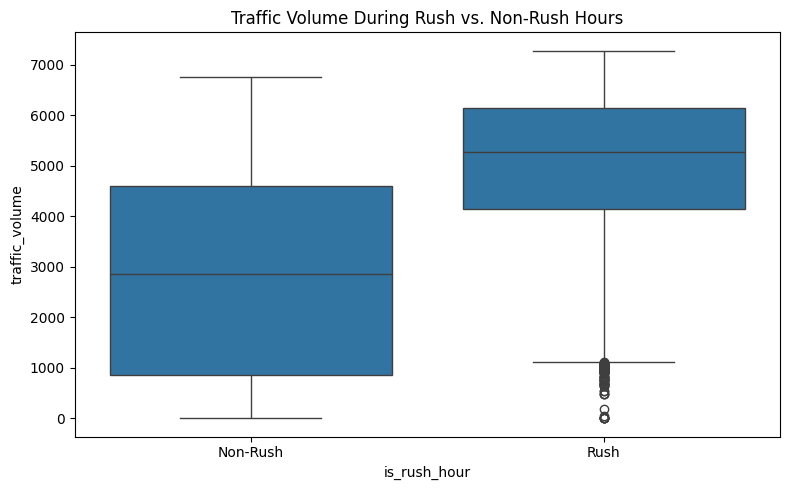

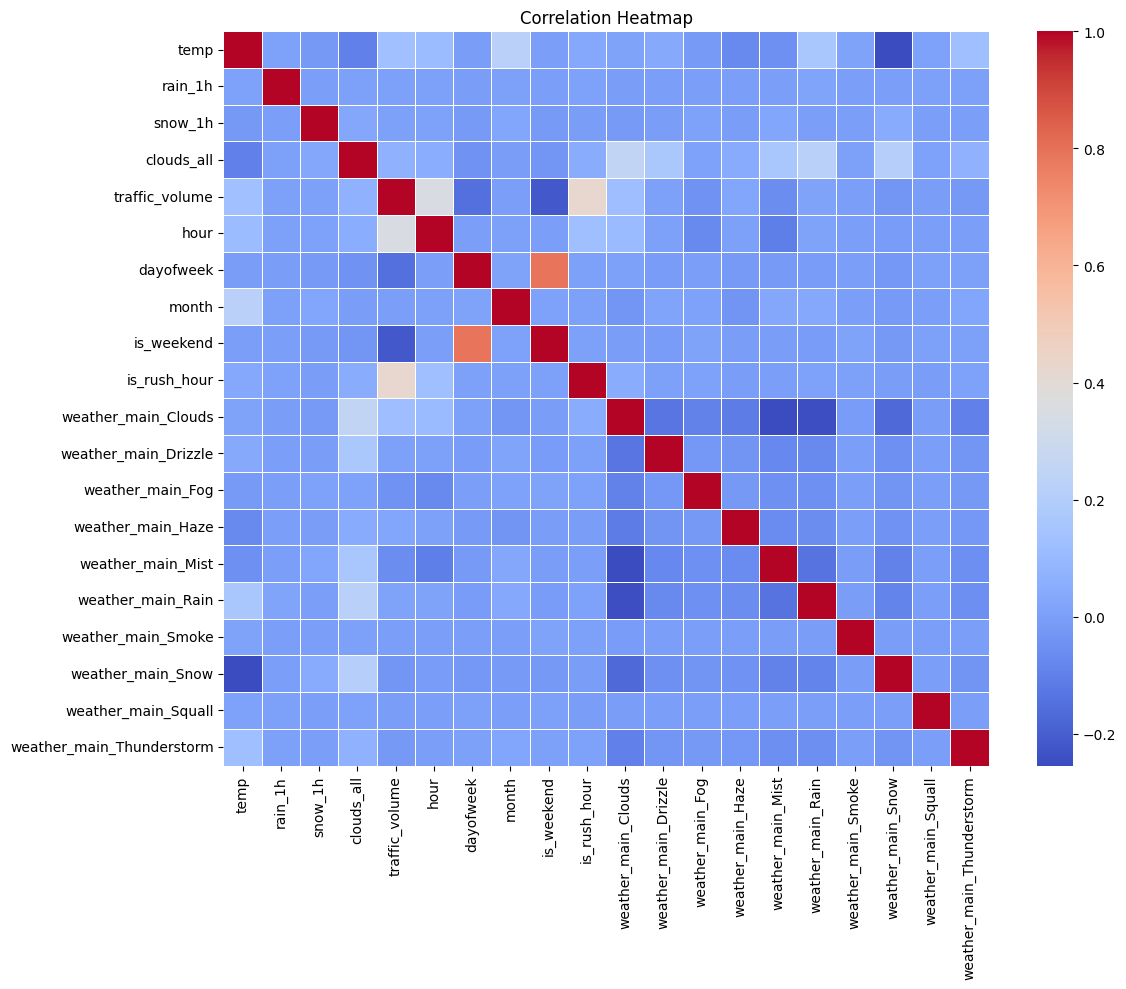


📋 FINAL MODEL SUMMARY
Model: Random Forest Regressor (100 trees)
Training Accuracy (R²): 0.9928
Testing Accuracy  (R²): 0.9488
Feature with Highest Importance: hour (0.8172)
✅ Model performs well with good generalization!


In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])

# Time features
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 16, 17, 18]).astype(int)

# Drop unnecessary columns
df.drop(columns=['date_time', 'holiday', 'weather_description'], inplace=True)

# One-hot encode categorical weather_main
df = pd.get_dummies(df, columns=['weather_main'], drop_first=True)

# Normalize continuous weather features
scaler = StandardScaler()
weather_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
df[weather_cols] = scaler.fit_transform(df[weather_cols])

# -------------------------------
# Splitting Data
# -------------------------------

X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Train Model
# -------------------------------

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# -------------------------------
# Predictions
# -------------------------------

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# -------------------------------
# Evaluation
# -------------------------------

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("✅ MODEL EVALUATION")
print(f"Training MSE      : {train_mse:.2f}")
print(f"Training R² Score : {train_r2:.4f}")
print(f"Testing MSE       : {test_mse:.2f}")
print(f"Testing R² Score  : {test_r2:.4f}")

# -------------------------------
# Feature Importance
# -------------------------------

importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importances.sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# -------------------------------
# Visualizations
# -------------------------------

# Traffic Volume by Hour
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='traffic_volume', data=df, estimator='mean')
plt.title("Average Traffic Volume by Hour of Day")
plt.grid(True)
plt.tight_layout()
plt.show()

# Rush Hour vs Non-Rush Hour
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_rush_hour', y='traffic_volume', data=df)
plt.title("Traffic Volume During Rush vs. Non-Rush Hours")
plt.xticks([0, 1], ['Non-Rush', 'Rush'])
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# -------------------------------
# Final Summary
# -------------------------------

print("\n📋 FINAL MODEL SUMMARY")
print("Model: Random Forest Regressor (100 trees)")
print(f"Training Accuracy (R²): {train_r2:.4f}")
print(f"Testing Accuracy  (R²): {test_r2:.4f}")
print(f"Feature with Highest Importance: {importances.idxmax()} ({importances.max():.4f})")

if test_r2 < 0.85:
    print("Consider changind the hyperparameters or using a more powerful model like XGBoost or LightGBM.")
else:
    print("✅ Model performs well with good generalization!")
